In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. EDA

Leitura do dataset principal

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ProjetosDataScience/Previsao_Demandas/train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,650430,2014-01-02,1,AUTOMOTIVE,3.0,0
1,650431,2014-01-02,1,BABY CARE,0.0,0
2,650432,2014-01-02,1,BEAUTY,6.0,0
3,650433,2014-01-02,1,BEVERAGES,2524.0,0
4,650434,2014-01-02,1,BOOKS,0.0,0


Avaliar quantidade de linhas

In [ ]:
print(f'Quantidade de linhas no dataset: {train.shape[0]}')

Quantidade de linhas no dataset: 205095


Metadados

In [ ]:
# Metadados referente ao conjunto de dados
def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

pod_academy_generate_metadata(train)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,id,int64,0,0.0,205095
1,date,object,0,0.0,1243
2,store_nbr,int64,0,0.0,5
3,family,object,0,0.0,33
4,sales,float64,0,0.0,50159
5,onpromotion,int64,0,0.0,229


Temos 5 lojas e 33 famílias de produtos no dataset.

In [ ]:
# Convertendo a coluna date para datetime
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year

# Criando a variável que indica o mês de referência
train['month_reference'] = train['date'].dt.strftime('%Y%m')
train

,id,date,store_nbr,family,sales,onpromotion,year,month_reference
0,650430,2014-01-02,1,AUTOMOTIVE,3.000,0,2014,201401
1,650431,2014-01-02,1,BABY CARE,0.000,0,2014,201401
2,650432,2014-01-02,1,BEAUTY,6.000,0,2014,201401
3,650433,2014-01-02,1,BEVERAGES,2524.000,0,2014,201401
4,650434,2014-01-02,1,BOOKS,0.000,0,2014,201401
...,...,...,...,...,...,...,...,...
205090,2865154,2017-05-31,5,POULTRY,228.597,0,2017,201705
205091,2865155,2017-05-31,5,PREPARED FOODS,62.246,2,2017,201705
205092,2865156,2017-05-31,5,PRODUCE,1955.523,161,2017,201705
205093,2865157,2017-05-31,5,SCHOOL AND OFFICE SUPPLIES,1.000,0,2017,201705


* Testes de sanidade
  * Checagem dos principais números, alguns exemplos:
    * Quantidade de vendas por mês de referência;
    * Observar o comportamento de venda em função da data / loja / família do produto / promoção.

#### 1.1 Quantidade de vendas por mês de referência

In [ ]:
df_ref_sales = train.groupby('month_reference')['sales'].sum().reset_index()

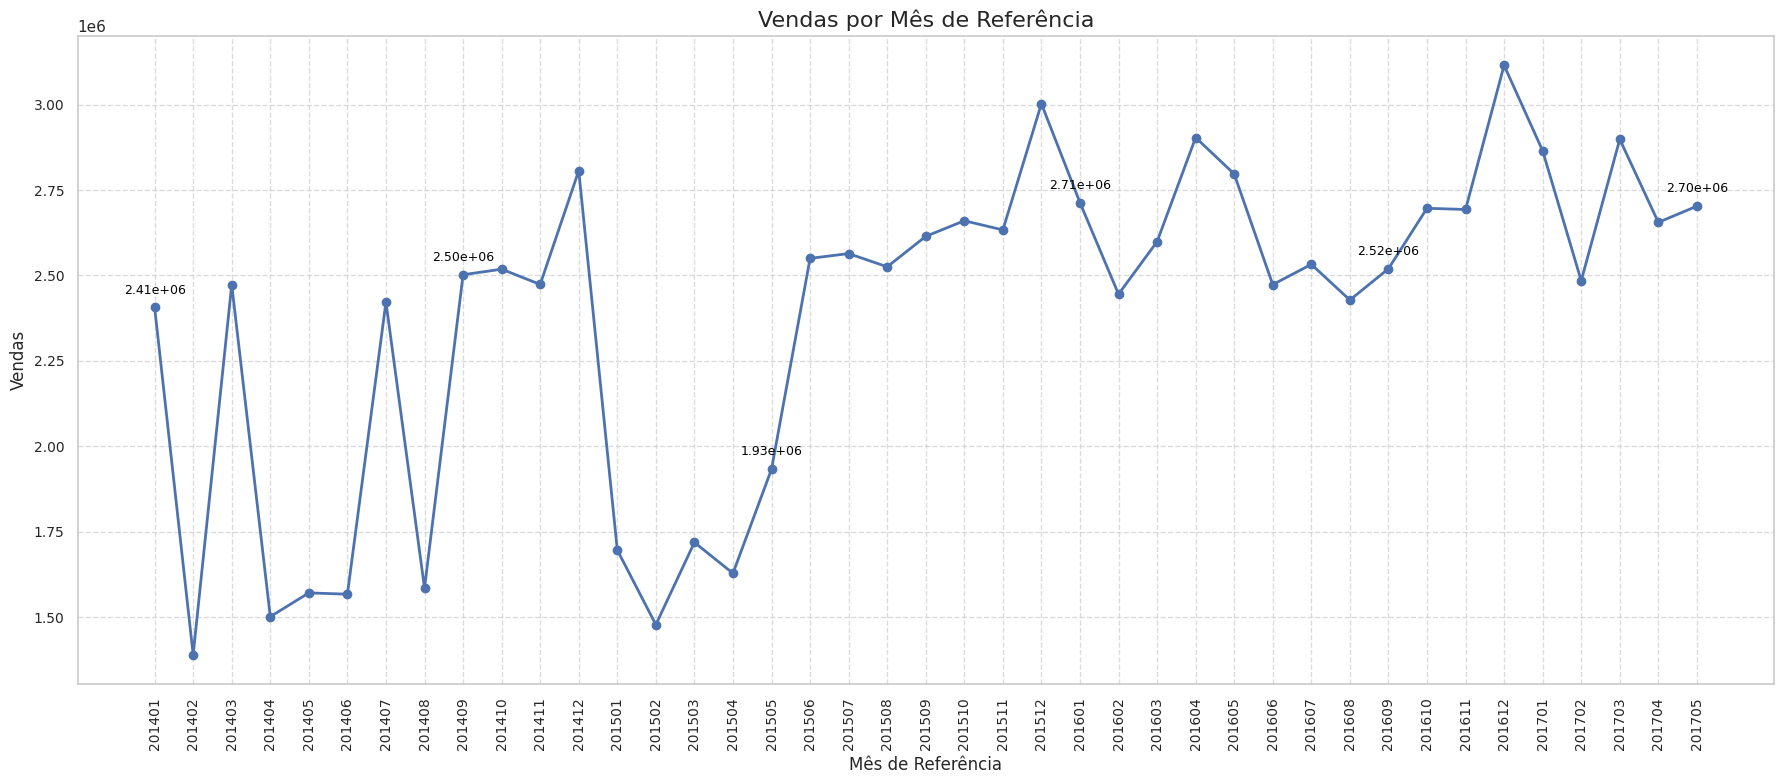

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de linhas com melhorias na estética
plt.figure(figsize=(18, 8))
plt.plot(df_ref_sales['month_reference'].astype(str), df_ref_sales['sales'], marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Vendas por Mês de Referência', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Adicionando anotações para alguns pontos
for i in range(0, len(df_ref_sales), 8):  # Anotando a cada 6 meses, por exemplo
    plt.annotate(f'{df_ref_sales["sales"].iloc[i]:.2e}',
                 (df_ref_sales['month_reference'].astype(str).iloc[i], df_ref_sales['sales'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='black')

plt.show()

Observações a respeito do gráfico:
1. Grande oscilação na quantidade de vendas entre 201401 e 201506. A oscilação máxima, na quantidade vendida entre dois meses consecutivos, nesse período atingiu mais de 1 milhão de unidades. Valor consideravelmente alto tendo em vista a escala dos valores de vendas neste gráfico;
2. A partir de 201506 as oscilações são bem menores.
3. Notam-se efeitos sazonais de redução e aumento na quantidade de vendas em fevereiro e dezembro, respectivamente.

Normalmente, investigamos o tópico "1" de modo a descobrir qual foi a origem daquele efeito. Uma possível explicação seria algum evento que impactou alguma ou até mesmo mais de uma loja. Deste modo, poderíamos delimitar o problema e buscar a solução de maneira mais eficiente. Diante deste cenário, vamos investigar se houve algum comportamento diferente em alguma das lojas neste período.

#### 1.2 Quantidade de vendas por loja em cada mês de referência

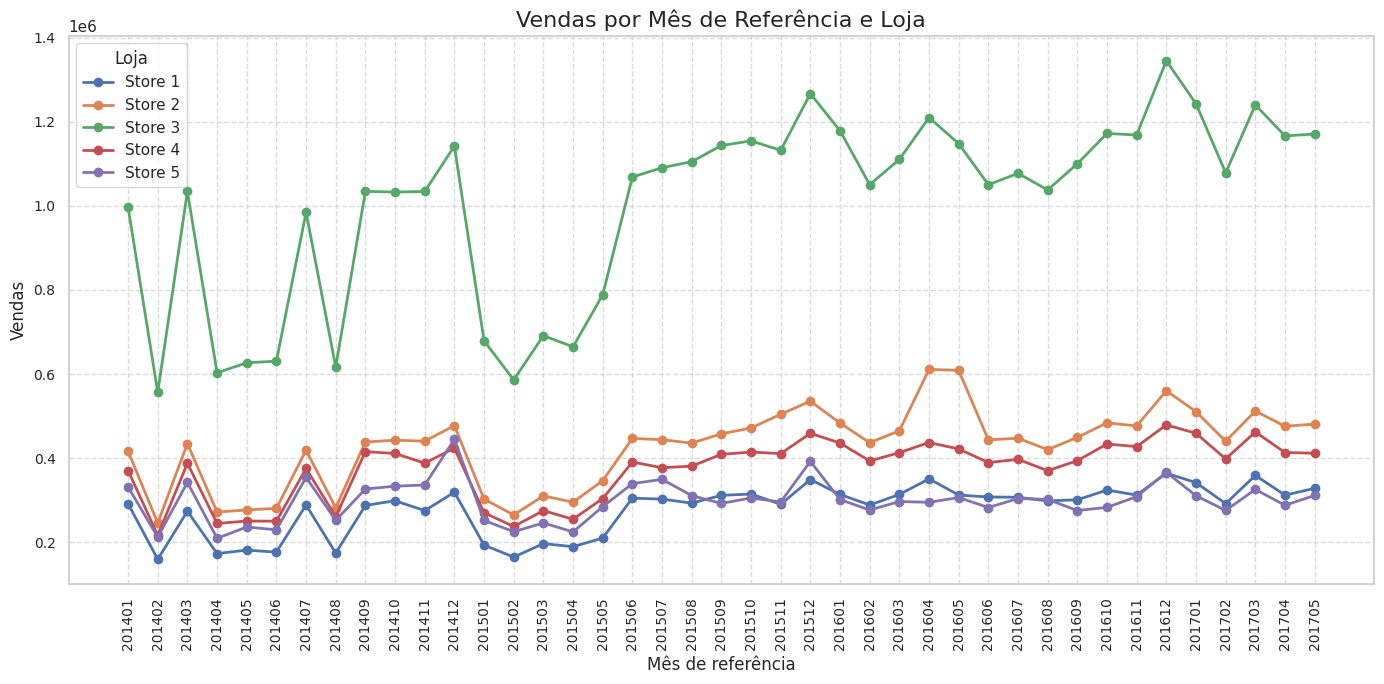

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

df_ref_store_sales = train.groupby(['month_reference','store_nbr'])['sales'].sum().reset_index()

# Supondo que o dataframe se chame df_store_sales
# plotando o gráfico de linhas
plt.figure(figsize=(14, 7))

# Criando uma linha para cada store_nbr
for store in df_ref_store_sales['store_nbr'].unique():
    store_data = df_ref_store_sales[df_ref_store_sales['store_nbr'] == store]
    plt.plot(store_data['month_reference'], store_data['sales'], marker='o', linestyle='-', label=f'Store {store}', linewidth=2)

plt.xlabel('Mês de referência', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Vendas por Mês de Referência e Loja', fontsize=16)
plt.xticks(df_ref_store_sales['month_reference'].unique(), rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Loja')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

A partir da interpretação do gráfico, notamos que a loja 3 vende bem mais que as demais, entretanto todas as lojas apresentam o mesmo comportamento entre 201401 e 201506.

Ainda não encontramos a explicação para este fenômeno. Vamos investigar o preço do petróleo no tempo pois sabemos que esta variável afeta o comportamento de vendas nesta empresa.

In [ ]:
oil = pd.read_csv('/content/drive/MyDrive/ProjetosDataScience/Previsao_Demandas/oil.csv')

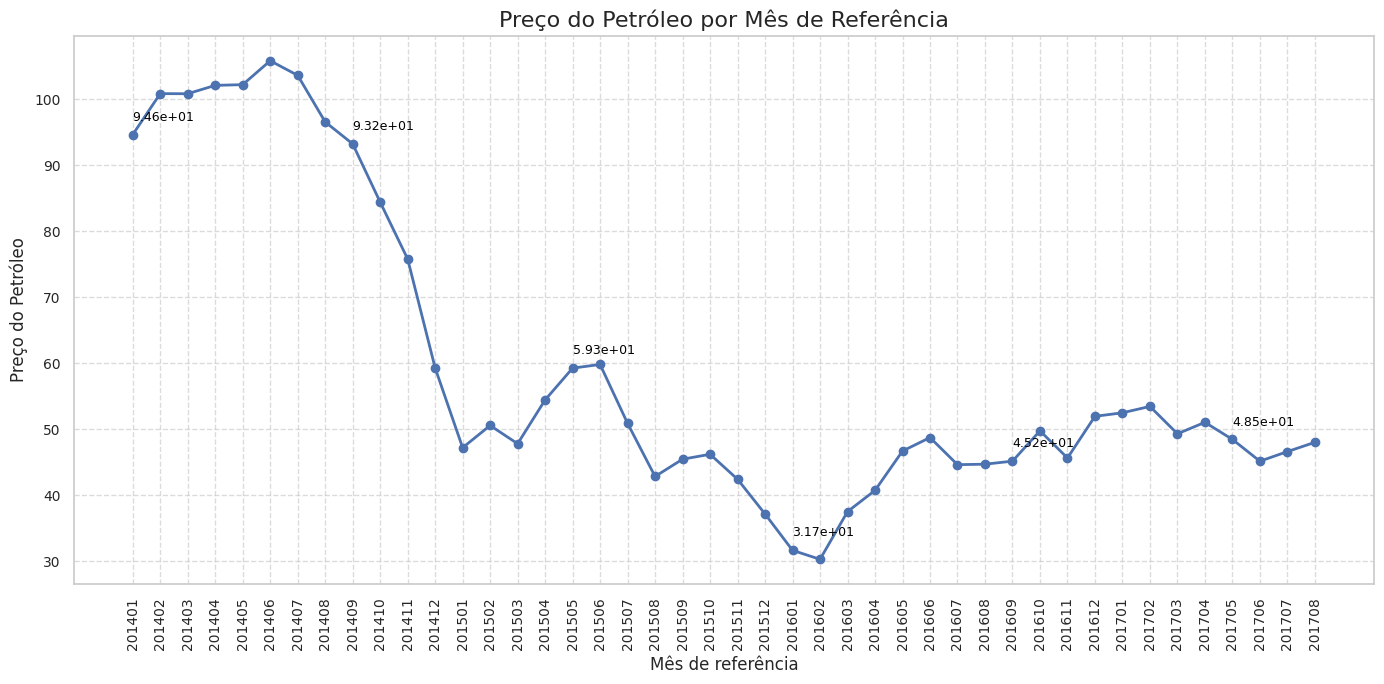

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Convertendo a coluna 'date' para datetime
oil['date'] = pd.to_datetime(oil['date'])

# Criando uma nova coluna 'month_reference' para o ano e mês
oil['month_reference'] = oil['date'].dt.strftime('%Y%m')

# Agrupando por 'month_reference' e calculando a média dos preços
df_oil_monthly = oil.groupby('month_reference')['price'].mean().reset_index()

# Plotando o gráfico de linhas
plt.figure(figsize=(14, 7))

plt.plot(df_oil_monthly['month_reference'].astype(str), df_oil_monthly['price'], marker='o', linestyle='-', linewidth=2)

plt.xlabel('Mês de referência', fontsize=12)
plt.ylabel('Preço do Petróleo', fontsize=12)
plt.title('Preço do Petróleo por Mês de Referência', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Adicionando anotações para alguns pontos
for i in range(0, len(df_oil_monthly), 8):  # Anotando a cada 6 meses, por exemplo
    plt.annotate(f'{df_oil_monthly["price"].iloc[i]:.2e}',
                 (df_oil_monthly['month_reference'].astype(str).iloc[i], df_oil_monthly['price'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='left', fontsize=9, color='black')

plt.show()

Ainda não encontramos a razão para a oscilação nos primeiros meses, entretanto notamos uma possível explicação para o aumento na quantidade de vendas em função da redução no preço de petróleo. Isso porque alguns dos efeitos provocados por preços elevados de petróleo são:
* Aumento dos Custos de Produção de produtos cuja matéria prima é o petróleo. Exemplos: Plásticos, borrachas sintéticas, solventes, fertilizantes, etc;
* Aumento dos Custos de Transporte pois o petróleo é a principal fonte de combustível para transporte (gasolina, diesel, etc.).

Sobre as oscilações observadas nos primeiros meses, deveríamos entender com a área de negócio se houve alguma ação que possa justificar esse comportamento, exemplo: alterações nas ofertas/campanhas.

#### 1.3 Quantidade de vendas por família de produto

In [ ]:
df_family_sales = train.groupby(['family'])['sales'].sum().reset_index().sort_values(by=['sales'],ascending=False)

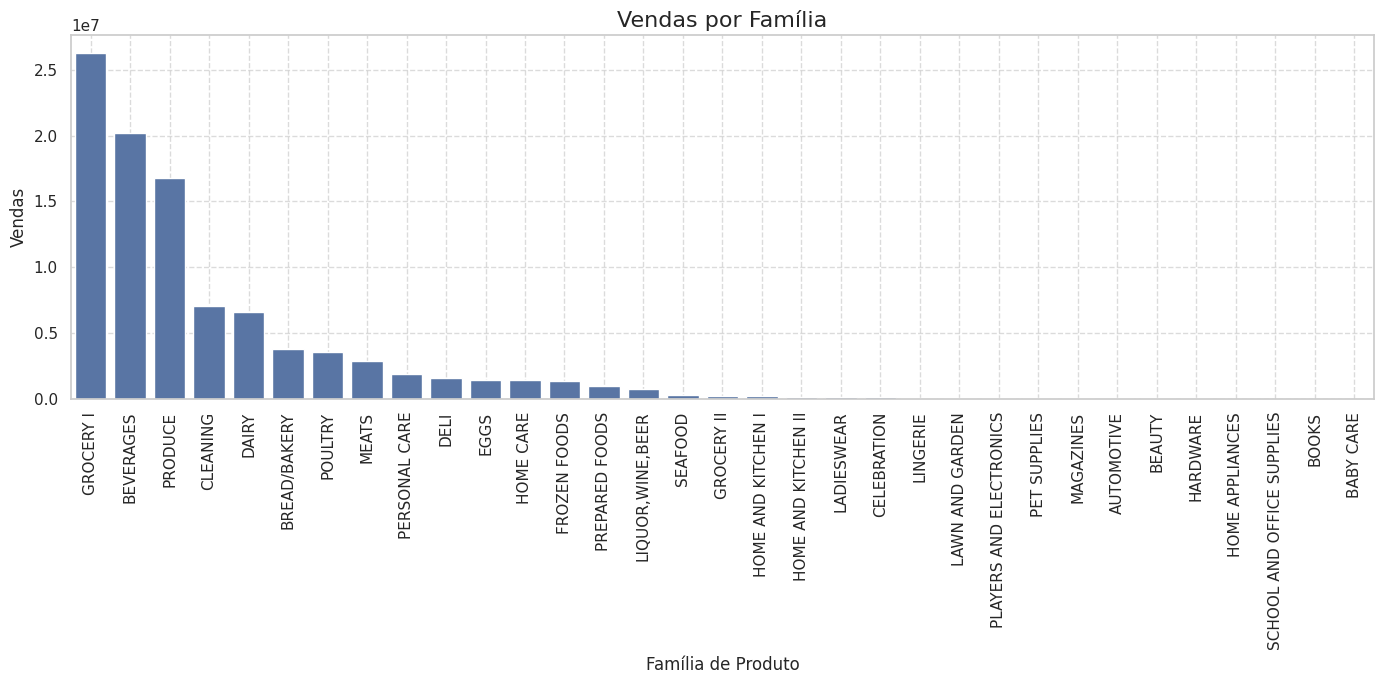

In [ ]:
# Criando o gráfico de barras
plt.figure(figsize=(14, 7))

# Plotando os dados
sns.barplot(data=df_family_sales, x='family', y='sales')

# Adicionando rótulos e título
plt.xlabel('Família de Produto', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Vendas por Família', fontsize=16)
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

A partir deste gráfico, obtemos os produtos de maior demanda ao longo do tempo. As 5 famílias de produtos mais procurados são:
* GROCERY I - Mercearia;
* BEVERAGES - Bebidas;
* PRODUCE - Hortifruti;
* CLEANING - Limpeza;
* DAIRY - Laticínios.

#### 1.4 Quantidade de vendas em função da ocorrência de promoções

In [ ]:
train['flag_promotion'] = train['onpromotion'].apply(lambda x: 1 if x > 0 else 0)
df_onpromotion_sales_year = train.groupby(['year','flag_promotion'])['sales'].sum().reset_index()

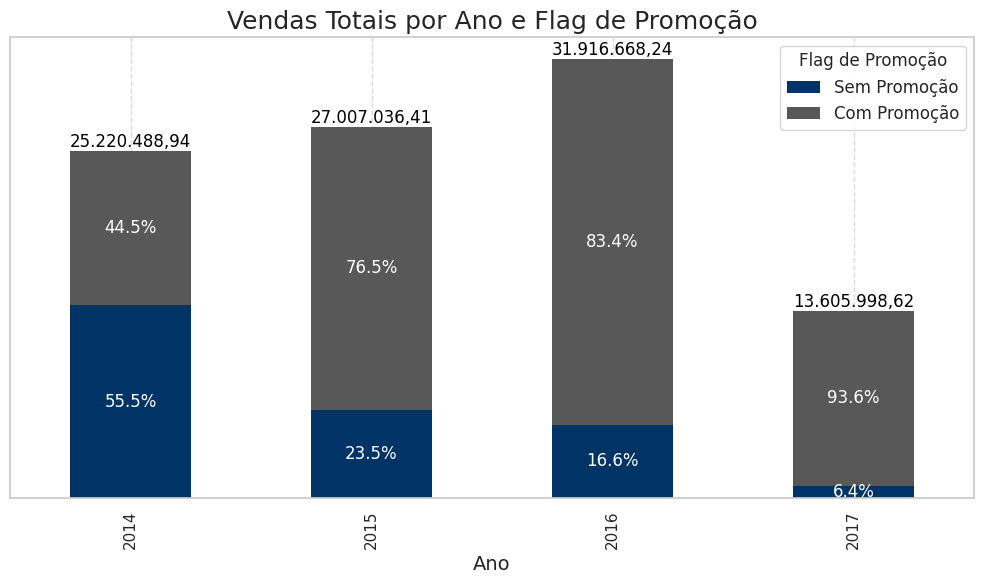

In [ ]:
def format_number(value):
    # Formata o número como float com duas casas decimais
    formatted_number = f'{value:,.2f}'
    # Troca vírgulas por pontos e pontos por vírgulas para o estilo brasileiro
    return formatted_number.replace(',', 'X').replace('.', ',').replace('X', '.')

# Pivotando o DataFrame para obter os dados no formato correto para barras empilhadas*
df_pivot = df_onpromotion_sales_year.pivot(index='year', columns='flag_promotion', values='sales').fillna(0)

# Calculando percentuais
df_percent = df_pivot.divide(df_pivot.sum(axis=1), axis=0) * 100

# Plotando o gráfico de barras empilhadas
colors = ['#003366', '#585858']
ax = df_pivot.plot(kind='bar', stacked=True, color=colors, edgecolor='none',figsize=(10, 6))

# Removendo o eixo vertical
ax.yaxis.set_visible(False)

# Adicionando rótulos de percentual em cada barra
for i, year in enumerate(df_pivot.index):
    heights = df_pivot.loc[year]
    percentages = df_percent.loc[year]
    bottom = 0

    for j, (height, percentage) in enumerate(zip(heights, percentages)):
        rect = ax.patches[i]
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x() + width / 2
        y = rect.get_y() + height / 2
        ax.annotate(f'{percentage:.1f}%', xy=(x, y), ha='center', va='center', fontsize=12, color='white')
        bottom += height

        i += len(df_pivot.index)

# Adicionando os valores totais no topo das barras
for i, year in enumerate(df_pivot.index):
    total_height = df_pivot.loc[year].sum()
    rect = ax.patches[df_pivot.shape[0]+i]
    width = rect.get_width()
    x = rect.get_x() + width / 2
    y = rect.get_y() + rect.get_height()
    formatted_number = format_number(total_height)
    ax.annotate(f'{formatted_number}', xy=(x, y), ha='center', va='bottom', fontsize=12, color='black')

# Adicionando rótulos e título
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Vendas', fontsize=14)
plt.title('Vendas Totais por Ano e Flag de Promoção', fontsize=18)
plt.legend(title='Flag de Promoção', labels=['Sem Promoção', 'Com Promoção'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Observamos que a partir de 2015, a maior parte das vendas ocorreram durante promoções.